# Analysing A subset of data from Experiment 68 (166K-member Level 3 library)

Python version


In [ ]:
from Bio import SeqIO, Align
from Bio.Seq import Seq
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wimpy import wimpy as wp

%load_ext autoreload
%autoreload 2


## Loading input data

In the example script, we use Nanopore sequencing output of the CLASSIC 166k library [REF] as example. The library consists of two genes, one expressing a synthetic transcription factor (SynTF), and the other a GFP reporter:

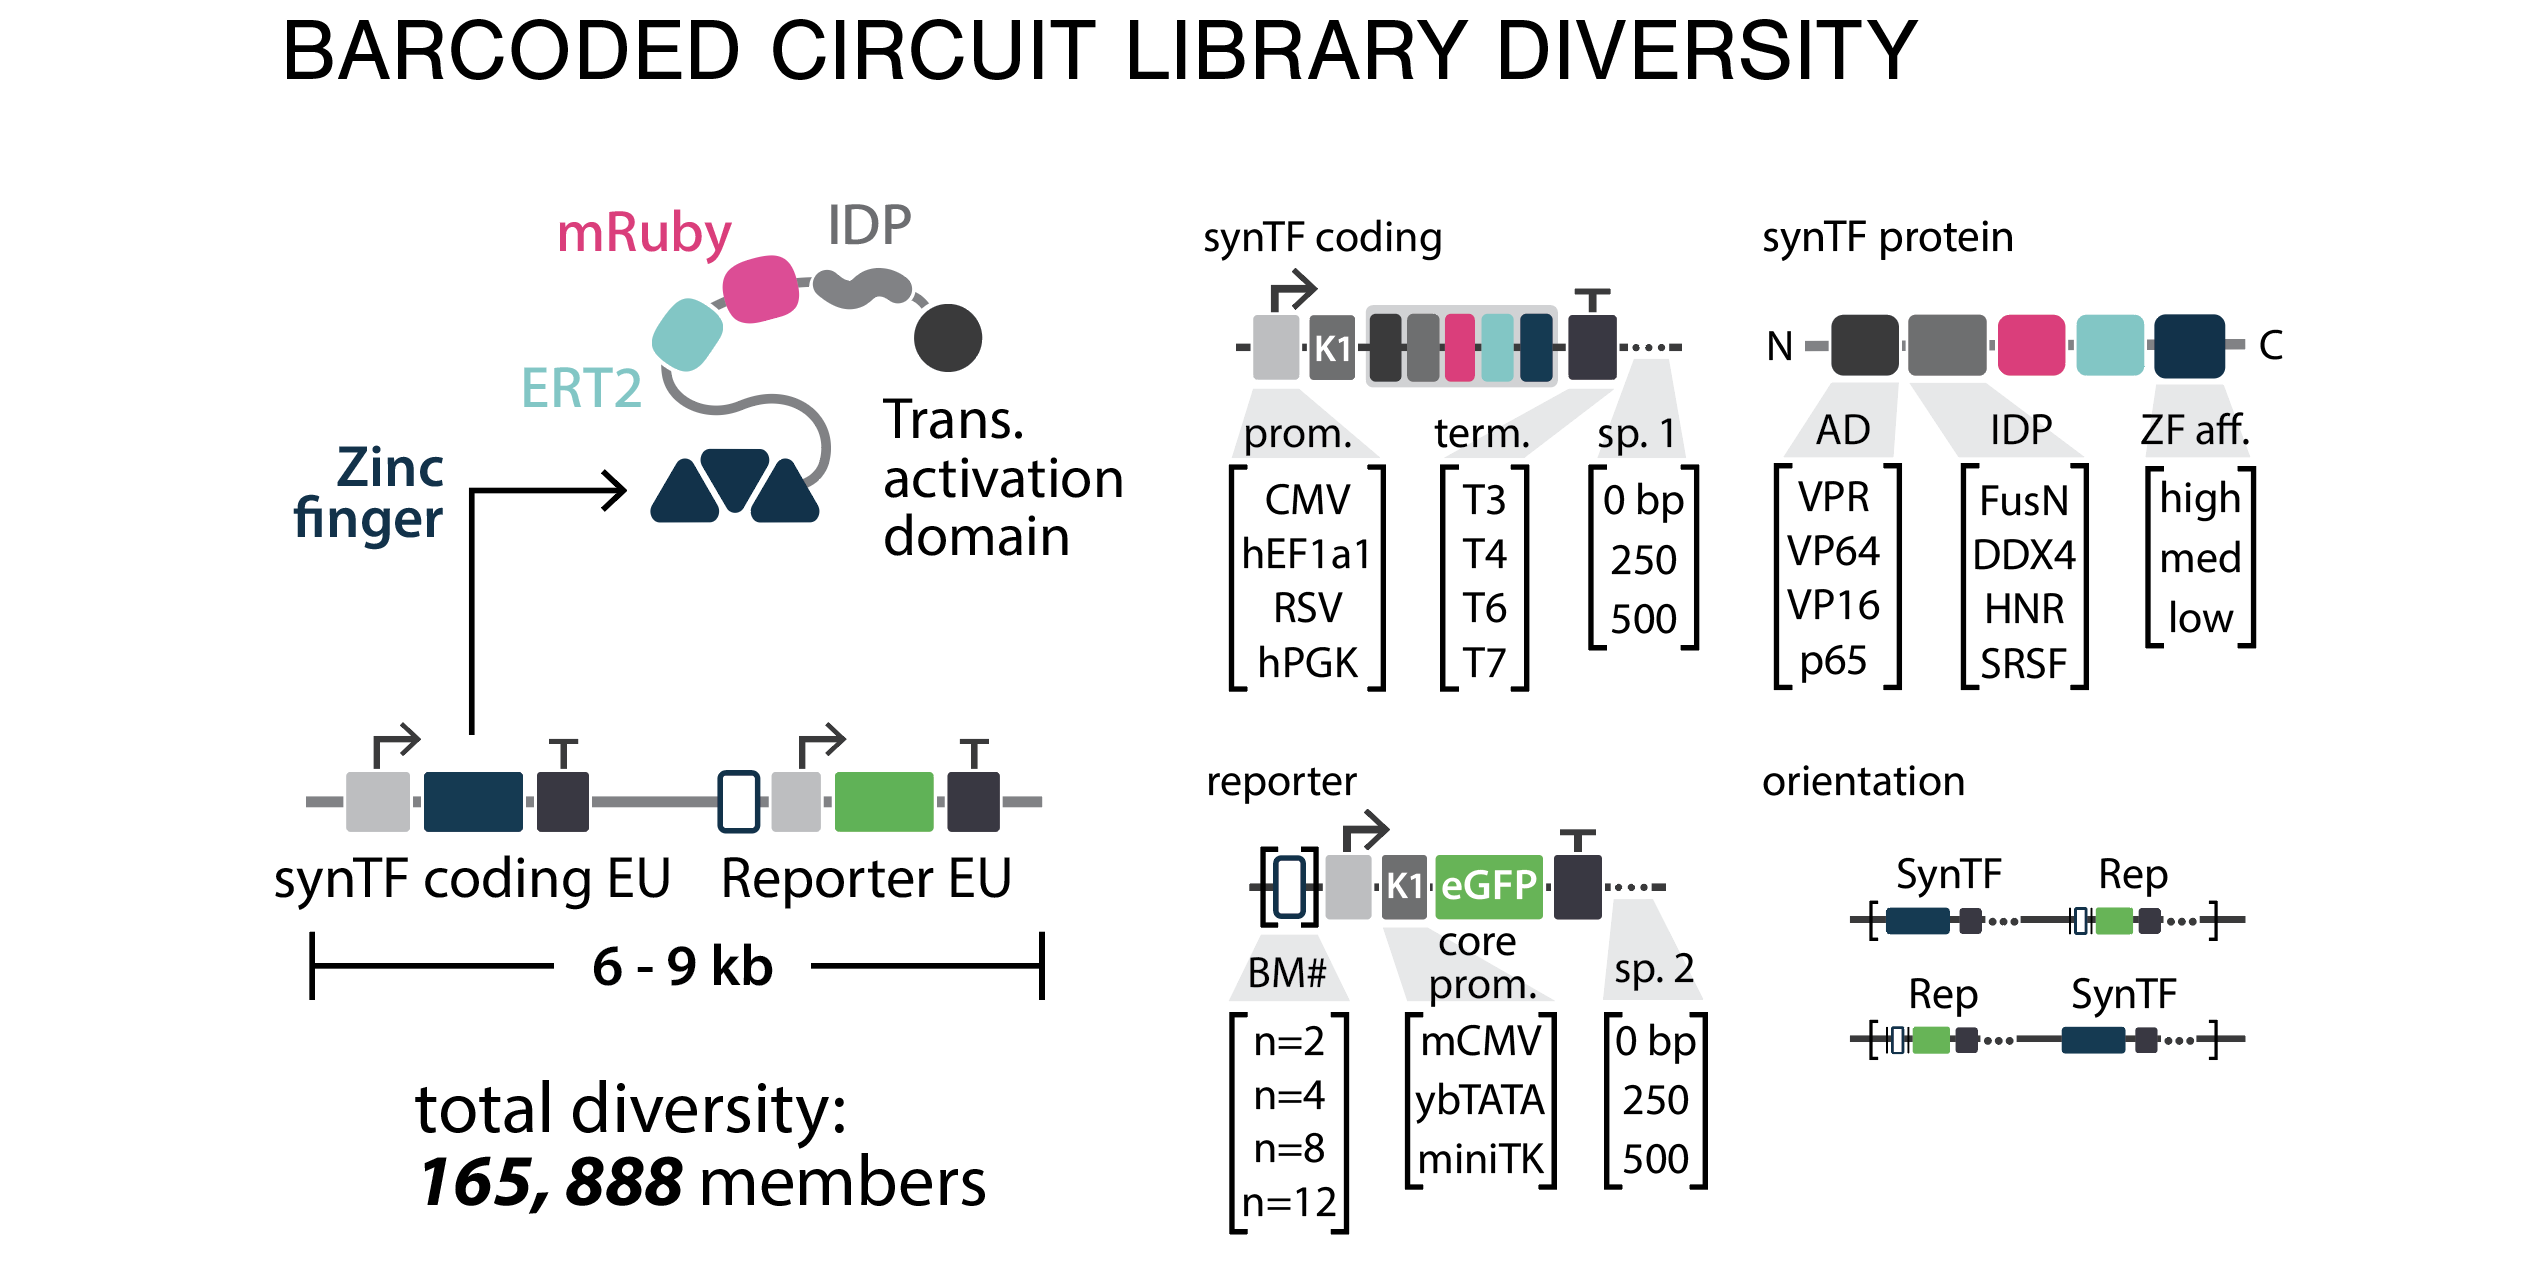

Each unit has multiple components that can vary, each chosen from one of several options (for example, promoter of SynTF unit can be CMV, hEF1a1, RSV, or hPGK).


In [ ]:
# reference sequences from input fasta file
with open(r"../example_ref_sequences/ref_sequences.fasta") as ref_fasta_file:
    ref_seqs = {
        record.id: str(record.seq) for record in SeqIO.parse(ref_fasta_file, "fasta")
    }
    
Puro = ref_seqs['Puro']
GFP = ref_seqs['GFP'][-100:]
A4 = ref_seqs['A4'][-50:]
minP = ref_seqs['minP']
mRuby = ref_seqs['mRuby'][200:300]
BFP = ref_seqs['BFP'][200:300]
ZF_parts = [ref_seqs['WT'], ref_seqs['C1_WT'], ref_seqs['C1_6x']]

# reference sequences from excel files
minP_100k = pd.read_excel(r'../example_ref_sequences/100k_Minimal-Promoters.xlsx')['Sequence'].to_list()
terminators_100k = pd.read_excel(r'../example_ref_sequences/100k_Terminators.xlsx')['Sequence'].to_list()
promoters_100k = pd.read_excel(r'../example_ref_sequences/100k-Promoters.xlsx')['Sequence'].to_list()
ORF_parts = pd.read_excel(r'../example_ref_sequences/100k_ORF-Parts_SynTF.xlsx')['SEQUENCE'].to_list()
AD_parts, IDR_parts = ORF_parts[0:4], ORF_parts[4:8]


Loading input Nanopore sequencing files with `fastqall`, and filter out all reads that are not within the expected size range (9500 to 15000 in this case):

In [ ]:
# load in data
_, l, seqs = wp.fastqall('../example_fastq/')
l, seqs = np.array(l), np.array(seqs)

# filter based on read length
seqs = seqs[(l > 9500) & (l < 15000)]
l = l[(l > 9500) & (l < 15000)]


Initial aliment with `bowtile`. In this example, every read should contain a puromycin (`Puro`) resistance gene. Therefore, we use `Puro` as the anchor point and re-index all reads to start with `Puro`.

The fastq file from nanopore contains plasmids that are read both in forward and reverse-complement direction. The ones sequences in reverse are flipped by `bowtile` so the ouput is all in forward direction.

In [ ]:
# bowtile for alignment
new_seq, _, _ = wp.bowtile(seqs, Puro, thresh=0.03)
new_seq = np.array(new_seq)

# filter out failed attempts
reads_correct = new_seq[new_seq != '']
l_reads_correct = l[new_seq != '']
num_seqs = len(reads_correct)

## Part Identification

This part of the script identifies the parts that are varied.


### Locating key landmarks

Locate key landmark regions via `tilepin_v2` (an upgraded version of the original `tilepin`, which uses hashmap to improve performance. See bottom of the notebook for performance comparison). We use the index of these landmarks to help locate the varied regions with multiple parts.

In [ ]:
_, positions_GFP, _ = wp.tilepin_v2(reads_correct, GFP, thresh=0.03, verbose=True)
_, positions_mRuby, _ = wp.tilepin_v2(reads_correct, mRuby, thresh=0.03, verbose=True)
_, positions_A4, _ = wp.tilepin_v2(reads_correct, A4, thresh=0.03, verbose=True)
_, positions_minP, _ = wp.tilepin_v2(reads_correct, minP, thresh=0.03, verbose=True)
_, positions_BFP, _ = wp.tilepin_v2(reads_correct, BFP, thresh=0.03, verbose=True)

### Reporter Unit Identification

We start by identifying the parts within the repoter expression unit. To start, we cut out promoter and terminator regions with `chophat`, which truncate the sequence based on a starting landmark, and either a ending landmark or a max region length. In our example, we select:

- `pregion`: promoter region, flanked between A4 [???] and GFP
- `tregion`: terminator region, starting with GFP and <= 2000 bp

In [ ]:
# pregions and tregions using chophat
p_regions = wp.chophat(reads_correct, positions_A4, end_positions=positions_GFP)
t_regions = wp.chophat(reads_correct, positions_GFP, max_length=2000)


#### Assign minimal promoter

`pregion` contains a minimal promoter, which can be one of the three variants (`minP_100k`). Here we use `viscount` to assign the read with its corresponding minimal promoter variant.

- since the sequence of minimal promoter is small, we use a smaller tile. This will increase misassignment rate, so we increased the threshold to accomodate for the higher error

In [ ]:
thresh = 0.2
minP_match_ratios, _ = wp.viscount(
    p_regions,
    minP_100k,
    thresh,
    tile_len=6,
    verbose=True,
    return_confusion_matrix=False,
)
minP_variants = np.argmax(minP_match_ratios, axis=1)
minP_variants[np.sum(minP_match_ratios, axis=1) < thresh] = -1

#### Assign number of binding sites

Based on the length of sequence, we set threshold for the length to determine how many binding sites are present in the sequence.


In [ ]:
bs_variants = np.zeros(num_seqs) - 1
dist = positions_minP - positions_A4
bs_variants[(dist > 0) & (dist < 160)] = 0 # 2 binding sites
bs_variants[(dist > 160) & (dist < 255)] = 1 # 4 binding sites
bs_variants[(dist > 255) & (dist < 415)] = 2 # 8 binding sites
bs_variants[(dist > 415) & (dist < 555)] = 3 # 12 binding sites


#### Assign terminators

Assign the terminator variants with `viscount`, similar to assigning minimal promoter variants

- In this example, terminator 0, 1, and 2 have very similar sequences so we need to make specific adjustments to distinguish them from each other

In [ ]:
_, term_variants_counts = wp.viscount(t_regions, terminators_100k, 0.2, return_confusion_matrix=False, verbose=True)

# custom scaling of terminators
term_variants_counts_adjusted = np.zeros((num_seqs, 3))
term_variants_counts_adjusted[:, 0] = term_variants_counts[:, 0]
term_variants_counts_adjusted[:, 1] = term_variants_counts[:, 1] - term_variants_counts[:, 0] * 1.5
term_variants_counts_adjusted[:, 2] = term_variants_counts[:, 2] - term_variants_counts[:, 1]
term_variants_counts_adjusted[term_variants_counts_adjusted < 10] = -1

term_variants = np.argmax(term_variants_counts_adjusted, axis=1)
term_variants[np.sum(term_variants_counts_adjusted, axis=1) < 1] = -1


Combine the variant assignment for the reporter unit

In [ ]:
reporter_variants = np.stack([bs_variants, minP_variants, term_variants]).T

### SynTF Unit Identification

Now we identify the parts in the SynTF unit. Similarly, we use `chophat` to find the region and `viscount` to assign variants

#### Assign promoter for SynTF unit

In [ ]:
thresh = 0.03

# chophat to find promoter regions for synTFs
pregions_synTF = wp.chophat(reads_correct, np.zeros_like(positions_minP), positions_minP)

# viscount to find best match for synTFs
synTF_prom_match_ratios, _, synTF_prom_conf = wp.viscount(pregions_synTF, promoters_100k, thresh=thresh, verbose=True)
synTF_prom_variants = np.argmax(synTF_prom_match_ratios, axis=1)
synTF_prom_variants[np.sum(synTF_prom_match_ratios, axis=1) < thresh] = -1

#### Assign ORF parts - activation domain

Here we use the other two output of `tilepin` to assign activation domain [???]

In [ ]:
AD_count, AD_match = [], []
for AD_part in AD_parts:
    count, _, match = wp.tilepin_v2(pregions_synTF, AD_part, thresh=1, verbose=True)
    AD_count.append(count)
    AD_match.append(match)
AD_count, AD_match = np.array(AD_count), np.array(AD_match)

In [ ]:
# activation domain confusion matrix
AD_conf = np.zeros((len(AD_parts), len(AD_parts)))

for i in range(len(AD_parts)):
    for j in range(len(AD_parts)):
        AD_conf[i, j] = np.sum((AD_count[i, :] > 30) & (AD_count[j, :] > 30))

# sequence-specific adjustments
AD_conf[3, 3] = np.sum((AD_count[3, :] > 10) & (AD_count[2, :] < 100))
AD_conf[2, 2] = np.sum(AD_count[2, :] > 100)
AD_conf[2, 3] = np.sum((AD_count[3, :] < 10) & (AD_count[2, :] > 100))
AD_conf[3, 2] = AD_conf[2, 3]

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(AD_conf)
plt.colorbar()
plt.show()

Assigning AD variants

In [ ]:
AD_count[AD_count < 30] = 0
AD_variants = np.argmax(AD_count, axis=0)
AD_variants[np.sum(AD_count, axis=0) == 0] = -1


Identifying end position of AD for each read

In [ ]:
# Initialize array to store activation domain positions
AD_position = np.zeros(num_seqs)

for i in range(num_seqs):
    if AD_variants[i] >= 0:
        # Extract matched positions for the assigned activation domain variant
        matches = AD_match[AD_variants[i]][i, :]
        pos_matches = np.arange(len(matches))[matches == 1]
        # Check if there are sufficient matches to compute the mean
        if len(pos_matches) > 10:
            AD_position[i] = np.floor(np.mean(pos_matches[-10:]))

# visualize AD positions
plt.figure(figsize=(4, 4))
plt.hist(AD_position, bins=100)
plt.show()

In [ ]:
# Match mRuby index to AD indices
mRuby_count, _, mRuby_match = wp.tilepin_v2(pregions_synTF, mRuby[:50], thresh=1, verbose=True)

mRuby_position = np.zeros(num_seqs)
for i in range(num_seqs):
    x = mRuby_match
    
for i in range(num_seqs):
    # Extract matched positions for the assigned activation domain variant
    matches = mRuby_match[i, :]
    pos_matches = np.arange(len(matches))[matches == 1]
    # Check if there are sufficient matches to compute the mean
    if len(pos_matches) > 4:
        mRuby_position[i] = np.floor(np.mean(pos_matches))
        
# visualize mRuby positions
plt.figure(figsize=(4, 4))
plt.hist(mRuby_position, bins=100)
plt.show()

### Identify IDRs in synTF_pregion using tiling


In [ ]:
IDR_len = mRuby_position - AD_position
IDR_tiles, _, IDR_conf = wp.viscount(
    pregions_synTF, 
    IDR_parts, 
    tile_len=10, 
    thresh=0.03, 
    return_confusion_matrix=True, 
    verbose=True
)

IDR_variants = np.argmax(IDR_tiles, axis=1) + 1
IDR_variants[(IDR_len < 500) & (IDR_len > 150)] = 0

# visualize confusion matrix
# plt.figure(figsize=(4, 4))
# plt.imshow(IDR_conf)
# plt.show()

In [ ]:
# Analyze Zinc Fingers
tregions_synTF = wp.chophat(reads_correct, positions_mRuby, end_positions=positions_A4)
ZF_tiles, _, ZF_conf = wp.viscount(tregions_synTF, ref_seqs=ZF_parts, thresh=0.03, tile_len=10, verbose=True)

ZF_variants = np.argmax(ZF_tiles, axis=1)
ZF_variants[np.sum(ZF_tiles, axis=1) == 0] = -1

# visualize confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(ZF_conf)
plt.show()

In [ ]:
# Analyze terminators using viscount
_, term_synTF_match_counts, _ = wp.viscount(
    tregions_synTF, 
    ref_seqs=terminators_100k, 
    thresh=0.03, 
    tile_len=10, 
    return_confusion_matrix=True, 
    verbose=True
)

# Initialize the scaled terminator variants
term_synTF_match_counts_scaled = np.zeros_like(term_synTF_match_counts)
threshold = 10
key_indices = [0, 3, 6, 9] 

# Process terminator variants
for i in range(num_seqs):  # Loop through rows (each variant)
    for k in key_indices:
        if term_synTF_match_counts[i, k] < threshold: continue

        term_synTF_match_counts_scaled[i, k] = term_synTF_match_counts[i, k]
        term_synTF_match_counts_scaled[i, k + 1] = term_synTF_match_counts[i, k + 1] - 175
        term_synTF_match_counts_scaled[i, k + 2] = term_synTF_match_counts[i, k + 2] - 350

# Determine indices of maximum scaled terminator variants
term_synTF_variants = np.argmax(term_synTF_match_counts_scaled, axis=1)

# Adjust indices based on summed thresholds
term_synTF_variants[np.sum(term_synTF_match_counts[:, key_indices], axis=1) < 20] = -1

# Calculate assignments for synTF variants
synTF_variants = np.stack([
    synTF_prom_variants,
    AD_variants,
    IDR_variants,
    ZF_variants,
    term_synTF_variants
]).T


In [ ]:
all_100k_variants = np.concatenate([synTF_variants, reporter_variants], axis=1)
library_100k = all_100k_variants @ np.array([1, 4, 16, 80, 240, 2880, 11520, 34560]).T
library_100k[np.any(all_100k_variants < 0, axis=1)] = -1

# visualize library balance
plt.figure()
plt.hist(library_100k[library_100k >= 0], bins=100)
plt.show()

## Barcoding & Barcoded AssTable Generation

In [ ]:
tregion_BFP = wp.chophat(reads_correct, positions_BFP, max_length=1000, retain=True)
# load barcode structure and substitution matrix
bba_construct = Seq("ATTATTATTATTATTATTA")
bba_sub_matrix = Align.substitution_matrices.Array(
    data=np.array([[5, -5, -5, -5], [-5, 5, 5, 5], [-5, 5, 5, 5], [-5, 5, 5, 5]]),
    alphabet="ATGC",
)
bba_aligner = Align.PairwiseAligner()
bba_aligner.mode = "local"
bba_aligner.substitution_matrix = bba_sub_matrix
bba_aligner.open_gap_score = -8
bba_aligner.extend_gap_score = -8

ddc_construct = Seq("CTTCTTCTTCTTCTTCTTC")
ddc_sub_matrix = Align.substitution_matrices.Array(
    data=np.array([[5, 5, 5, -5], [5, 5, 5, -5], [5, 5, 5, -5], [-5, -5, -5, 5]]),
    alphabet="ATGC",
)
ddc_aligner = Align.PairwiseAligner()
ddc_aligner.mode = "local"
ddc_aligner.substitution_matrix = ddc_sub_matrix
ddc_aligner.open_gap_score = -8
ddc_aligner.extend_gap_score = -8

In [ ]:
bba_barcode = np.empty(num_seqs, dtype='<U32')
bba_position = np.zeros(num_seqs, dtype=np.int32) - 1
bba_length = np.zeros(num_seqs, dtype=np.int32) - 1
bba_score = np.zeros(num_seqs, dtype=np.int32) - 1

ddc_barcode = np.empty(num_seqs, dtype='<U32')
ddc_position = np.zeros(num_seqs, dtype=np.int32) - 1
ddc_length = np.zeros(num_seqs, dtype=np.int32) - 1
ddc_score = np.zeros(num_seqs, dtype=np.int32) - 1

for i, seq in enumerate(tqdm(tregion_BFP, desc='searching barcode using alignment')):
    if len(seq) <= 0: continue

    alignment = bba_aligner.align(seq, bba_construct)[0]
    bba_barcode[i] = alignment[0]
    bba_position[i] = int(alignment.indices[0, 0])
    bba_length[i] = alignment.length
    bba_score[i] = alignment.score

    alignment = ddc_aligner.align(seq, ddc_construct)[0]
    ddc_barcode[i] = alignment[0]
    ddc_position[i] = int(alignment.indices[0, 0])
    ddc_length[i] = alignment.length
    ddc_score[i] = alignment.score


In [ ]:
is_valid_alignment = (bba_score > 85) & (ddc_score > 90)
is_fully_assigned = (library_100k >= 0)

bba_correct = bba_barcode[is_valid_alignment & is_fully_assigned]
ddc_correct = ddc_barcode[is_valid_alignment & is_fully_assigned]
barcoded_variants = all_100k_variants[is_valid_alignment & is_fully_assigned]


In [ ]:
barcoded_variants.shape

-------------------------

**Performance comparision** (benchmark machine: Apple M1 Macbook Air):
- MatLab version of `tilepin()`
  - 15 s for the last 100 bp of GFP reference sequence
  - 2 min for whole GFP reference sequence
- `wp.tilepin()`
  - 15 s for the last 100 bp of GFP reference sequence
  - 6 min for whole GFP reference sequence
- `wp.tilepin_v2()`
  - 15 s for the last 100 bp of GFP reference sequence
  - 18 s for whole GFP reference sequence


In [ ]:
_, positionsGFP1, _ = wp.tilepin(reads_correct, GFP, thresh=0.03, verbose=True)
_, positionsGFP2, _ = wp.tilepin_v2(reads_correct, GFP, thresh=0.03, verbose=True)
plt.figure(figsize=(4, 4))
plt.hist(positionsGFP1 - positionsGFP2, bins=np.arange(-50, 50))
plt.show()
